In [1]:
import os,pandas,dill,datetime,time,numpy
import matplotlib,matplotlib.pyplot
import miner
%matplotlib inline

In [2]:
# 0. user defined variables
inputDataFile='/Users/alomana/github/PSL/GBM/results/MA.data.csv'
outputDir='/Volumes/omics4tb2/alomana/projects/PSL/GBM/results/MINER/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)

In [3]:
# 1. input and preprocess expression data
expressionData=pandas.read_csv(inputDataFile,header=0,index_col=0,sep=",")
print('expression data shape',expressionData.shape)
expressionData,conversionTable=miner.identifierConversion(expressionData)

('expression data shape', (11312, 538))


miner.py:71: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  idMap = pd.read_table(conversionTable)


completed identifier conversion.
10663 genes were converted.


In [4]:
expressionData=miner.zscore(expressionData)

completed z-transformation.


(array([  1.,   7.,   1.,   8.,  17.,  16.,  36.,  47.,  80., 113., 139.,
        184., 249., 297., 342., 451., 575., 665., 693., 742., 715., 741.,
        659., 618., 480., 480., 393., 356., 305., 261., 201., 151., 136.,
        101.,  74.,  73.,  35.,  40.,  36.,  30.,  19.,  17.,  22.,   9.,
          8.,   5.,   7.,   5.,   2.,   5.,   1.,   2.,   2.,   2.,   0.,
          0.,   2.,   0.,   1.,   0.,   1.,   1.,   1.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-5.25634982e+00, -5.01735792e+00, -4.77836601e+00, -4.53937411e+00,
        -4.30038220e+00, -4.06139030e+00, -3.82239839e+00, -3.58340649e+00,
        -3.34441459e+00, -3.10542268e+00, -2.86643078e+00, -2.62743887e+00,
        -2.38844697e+00, -2.14945507e+00, -1.91046316e+00, -1.67147126e+00,
        -1.432

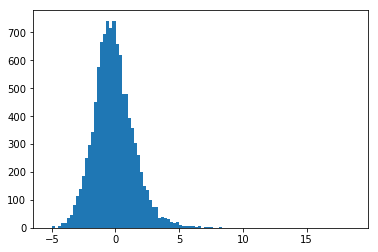

In [5]:
matplotlib.pyplot.hist(expressionData.iloc[:,0],bins=100)

In [6]:
# MINER parameters
minNumberGenes = 6 #bulk RNAseq default=6;single cell RNAseq default=6
minCorrelation = 0.2 #bulk RNAseq default=0.2;single cell RNAseq default=0.05
minNumberRegulonGenes = 5 #bulk RNAseq default=5;single cell RNAseq default=4
numCores = 8

t_start = time.time()
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=12,overExpressionThreshold=80) 
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(outputDir,"coexpressionDictionary.json"))

0.00 percent complete


/Users/alomana/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 15.28 minutes


Number of genes clustered: 10012
Number of unique clusters: 743


Text(0,0.5,'Number of clusters')

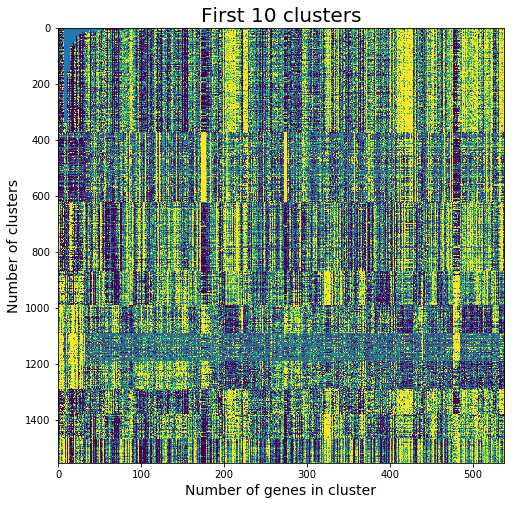

In [7]:
# visualize first 10 clusters
matplotlib.pyplot.figure(figsize=(8,8))
matplotlib.pyplot.imshow(expressionData.loc[numpy.hstack([revisedClusters[i] for i in range(10)]),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
matplotlib.pyplot.grid(False)
matplotlib.pyplot.ylabel("Genes",FontSize=20)
matplotlib.pyplot.xlabel("Samples",FontSize=20)
matplotlib.pyplot.title("First 10 clusters",FontSize=20)

# report coverage
print("Number of genes clustered: {:d}".format(len(set(numpy.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

# plot histogram of the cluster size distribution
counts_ = matplotlib.pyplot.hist([len(revisedClusters[key]) for key in revisedClusters.keys()],bins=100)
matplotlib.pyplot.xlabel("Number of genes in cluster",FontSize=14)
matplotlib.pyplot.ylabel("Number of clusters",FontSize=14)

In [9]:
t1 = time.time()
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,correlationThreshold=minCorrelation,numCores=numCores,dataFolder=os.path.join("..","data"))
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(outputDir,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(outputDir,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)
# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulonModules, regulonDf = miner.regulonDictionary(regulons)
# write regulons to json file
miner.write_json(regulonModules,os.path.join(outputDir,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(outputDir,"coexpressionModules.json"))
#reconvert revised clusters to original gene annotations
annotatedRevisedClusters = miner.convertDictionary(revisedClusters,conversionTable)
# write annotated coexpression clusters to .json file
miner.write_json(revisedClusters,os.path.join(outputDir,"coexpressionDictionary_annotated.json"))
#reconvert results into original annotations
regulonAnnotatedDf = miner.convertRegulons(regulonDf,conversionTable)
#write annotated regulon table to .csv
regulonAnnotatedDf.to_csv(os.path.join(outputDir,"regulons_annotated.csv"))
#reconvert regulons
annotatedRegulons = miner.convertDictionary(regulonModules,conversionTable)
# write annotated regulons to .json file
miner.write_json(regulons,os.path.join(outputDir,"regulons_annotated.json"))
#reconvert coexpression modules
annotatedCoexpressionModules = miner.convertDictionary(coexpressionModules,conversionTable)
# write annotated coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(outputDir,"coexpressionModules_annotated.json"))
t2 = time.time()
print("completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))
print(len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique()))

Running mechanistic inference
Completed mechanistic inference
completed mechanistic inference in 6.14 minutes
(443, 6901)


In [10]:
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(outputDir,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(outputDir,"underExpressedMembers.csv"))
dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
dysregulatedMembersMatrix.to_csv(os.path.join(outputDir,"dysregulatedMembers.csv"))
coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
coherentMembersMatrix.to_csv(os.path.join(outputDir,"coherentMembers.csv"))

done!
done!
done!
done!


In [ ]:
# infer bicluster membership

done!


TypeError: orderMembership() got an unexpected keyword argument 'outputDir'

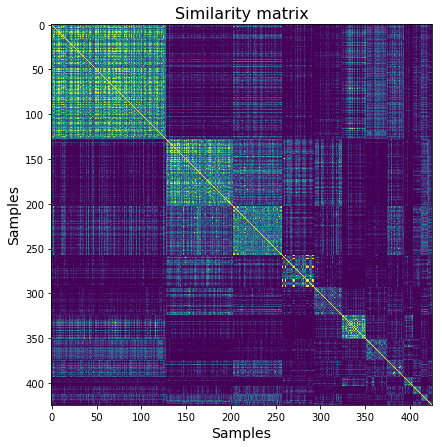

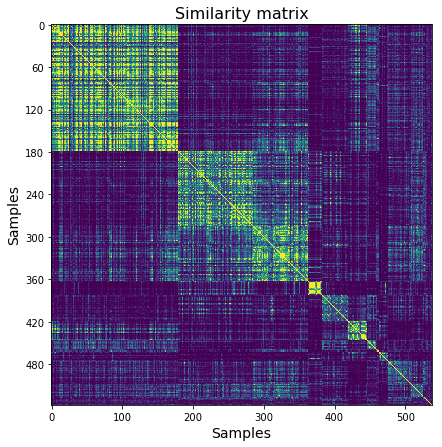

In [11]:
# choose membership type for sample class prediction
sampleDictionary = overExpressedMembers
sampleMatrix = overExpressedMembersMatrix
sampleUnderMatrix = underExpressedMembersMatrix

# perform initial subtype clustering
similarityClusters = miner.f1Decomposition(sampleDictionary,thresholdSFM=0.1)
initialClasses = [i for i in similarityClusters if len(i)>4]

# visualize initial results
sampleFrequencyMatrix = miner.sampleCoincidenceMatrix(sampleDictionary,freqThreshold = 0.333,frequencies=True) #0.333
similarityMatrix = sampleFrequencyMatrix*sampleFrequencyMatrix.T
miner.plotSimilarity(similarityMatrix,numpy.hstack(initialClasses),vmin=0,vmax=0.5,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(outputDir,"similarityMatrix_regulons.pdf"))

# expand initial subtype clusters
centroidClusters, centroidMatrix = miner.centroidExpansion(initialClasses,sampleMatrix,f1Threshold = 0.1,returnCentroids=True) #0.3
centroidMatrix.to_csv(os.path.join(outputDir,"centroids.csv"))
unmapped = list(sampleMatrix.columns[numpy.where(sampleMatrix.sum(axis=0)==0)[0]])
mappedSamples = [i for i in numpy.hstack(centroidClusters) if i not in unmapped]
mappedClusters = miner.mapExpressionToNetwork(centroidMatrix,sampleMatrix,threshold = 0.05)

# visualize expanded subtype clusters
miner.plotSimilarity(similarityMatrix,mappedSamples,vmin=0,vmax=0.333,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(outputDir,"centroidClusters_regulons.pdf"))

# Generate heatmaps of module activity
orderedOverExpressedMembers = miner.orderMembership(centroidMatrix,sampleMatrix,mappedClusters,ylabel="Modules",outputDir=None)
orderedDM = miner.plotDifferentialMatrix(overExpressedMembersMatrix,underExpressedMembersMatrix,orderedOverExpressedMembers,cmap="bwr",aspect="auto",saveFile=os.path.join(outputDir,"centroid_clusters_heatmap.pdf"))

# Infer transcriptional programs and states
programs, states = miner.mosaic(dfr=orderedDM,clusterList=centroidClusters,minClusterSize_x=9,minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(outputDir,"regulon_activity_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
mosaicDf = orderedDM.loc[numpy.hstack(program_list),numpy.hstack(states)]
mosaicDf.to_csv(os.path.join(outputDir,"regulons_activity_heatmap.csv"))

# Get eigengenes for all modules
eigengenes = miner.getEigengenes(referenceDictionary,expressionData,regulon_dict=None,saveFolder=None)

#write eigengenes to .csv
eigengenes.to_csv(os.path.join(outputDir,"eigengenes.csv"))

#plot eigengenes
matplotlib.pyplot.figure()
matplotlib.pyplot.imshow(eigengenes.loc[numpy.hstack(program_list),numpy.hstack(states)],cmap="viridis",vmin=-0.05,vmax=0.05,aspect="auto")
matplotlib.pyplot.grid(False)

# calculate percent of samples that fall into a state with >= minimum acceptable number of samples
groups = [states[i] for i in range(len(states)) if len(states[i])>=int(numpy.ceil(0.01*expressionData.shape[1]))]
print('Discovered {:d} transcriptional states and {:d} transcriptional programs'.format((len(states)),len(transcriptional_programs)))
print('sample coverage within sufficiently large states: {:.1f}%'.format(100*float(len(numpy.hstack(groups)))/expressionData.shape[1]))

#write all transcriptional program genesets to text files for external analysis
if not os.path.isdir(os.path.join(outputDir,"transcriptional_programs_coexpressionModules")):
    os.mkdir(os.path.join(outputDir,"transcriptional_programs_coexpressionModules"))
    
for tp in transcriptional_programs.keys():
    numpy.savetxt(os.path.join(outputDir,"transcriptional_programs_coexpressionModules",(".").join([tp,"txt"])),transcriptional_programs[tp],fmt="%1.50s")
    
# Determine activity of transcriptional programs in each sample
statesDf = miner.reduceModules(df=orderedDM,programs=program_list,states=states,stateThreshold=0.65,saveFile=os.path.join(outputDir,"transcriptional_programs_vs_samples.pdf"))

# Cluster patients into subtypes and give the activity of each program in each subtype
programsVsStates = miner.programsVsStates(statesDf,states,filename=os.path.join(outputDir,"programs_vs_states.pdf"))